In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jdcal
from rasterio.mask import mask
import os
import datetime
from tqdm import tqdm
os.chdir(os.path.abspath("").split('notebooks')[0])

from dbExplorer.rgi import Region
from dbExplorer.velocitiesDataCube import DataCube, Glacier, getServerFiles

# Explore local datacube

In [2]:
# First retrieve mapping information that doesn't exist in the processed datacubes
pathDc = 'data/dc/c_x01225_y03675_all_filt-multi.nc'
dc = DataCube(pathDc)
mapping = dc.mapping

pathDc = 'data/dc/c_x01225_y03675_interp.nc'
dc = DataCube(pathDc, mapping=mapping)
mapping = dc.mapping
dc.readAsTiff(drop_vars=['xcount_x', 'xcount_y']) # Remove some of the variables because the nodata field is not consistent between vx/vy and xcount_x/xcount_y

100%|██████████| 610/610 [00:42<00:00, 14.26it/s]


In [3]:
gid = 'RGI2000-v7.0-G-11-00773' # Bossons glacier

rgiAreaId = 11 # Europe
reg = Region(rgiAreaId)
glacierWgs84 = reg.gdf.loc[reg.gdf.rgi_id==gid]

files = [pathDc]
glacierDc = Glacier(glacierWgs84, files)
print(glacierDc)

In [4]:
dcContainingGlacier = glacierDc.getDataCubes(mapping=mapping, drop_vars=['xcount_x', 'xcount_y'])
assert len(dcContainingGlacier)==1, f"Glacier with ID {gid} should be in the datacube"
dc = dcContainingGlacier[0]

1it [00:00, 124.26it/s]
100%|██████████| 610/610 [00:42<00:00, 14.30it/s]


In [5]:
bottomlat, leftlon = dc.Ywgs.min(), dc.Xwgs.min()
toplat, rightlon = dc.Ywgs.max(), dc.Xwgs.max()
print(bottomlat, leftlon)
print(toplat, rightlon)

reg.filterArea(thresArea=1)
print(f"{len(reg.glaciersOfInterest)=}")
glaciers = reg.getGlacierInBox(leftlon, rightlon, toplat, bottomlat, useFiltered=True)
print(f"{len(glaciers)=}")

45.81853085350411 6.749984933553879
45.92746497255478 6.914644405156763
len(reg.glaciersOfInterest)=409


100%|██████████| 409/409 [00:01<00:00, 257.74it/s]

len(glaciers)=9


## Visualize glaciers that are in the datacube

RGI2000-v7.0-G-11-00688: Miage
RGI2000-v7.0-G-11-00691: Brouillard
RGI2000-v7.0-G-11-00693: Freney
RGI2000-v7.0-G-11-00695: Brenva
RGI2000-v7.0-G-11-00757: FR4N01236A01 Mer de Glace/Geant
RGI2000-v7.0-G-11-00773: FR4N01237D03 Bossons
RGI2000-v7.0-G-11-00774: FR4N01237E01 Taconnaz
RGI2000-v7.0-G-11-00778: FR4N01239A02 de Bionnassay
RGI2000-v7.0-G-11-00783: FR4N01239B03 du Miage 4


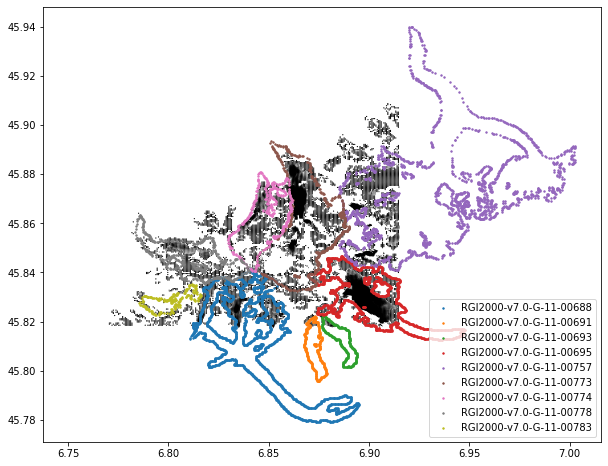

In [6]:
indS = 608

vx=dc.fnetcdf['vx'][:].filled(np.nan)
vy=dc.fnetcdf['vy'][:].filled(np.nan)

plt.figure(figsize=(10,8))
plt.quiver(dc.Xwgs,dc.Ywgs,vx[indS],-vy[indS])

for e,glacier in enumerate(glaciers):
    print(f"{glacier['rgi_id'].item()}: {glacier['glac_name'].item()}")
    borderPts = np.array(glacier.geometry.get_coordinates())
    plt.scatter(borderPts[:,0], borderPts[:,1], s=2, label=glacier['rgi_id'].item())
plt.legend(loc=4)
plt.show()

## Intersect the datacube with the Bossons glacier

In [7]:
out = {}
for date in dc.tiffs:
    out[date], _ = mask(dc.tiffs[date], glacierWgs84.geometry, invert=False, crop=False, filled=False)

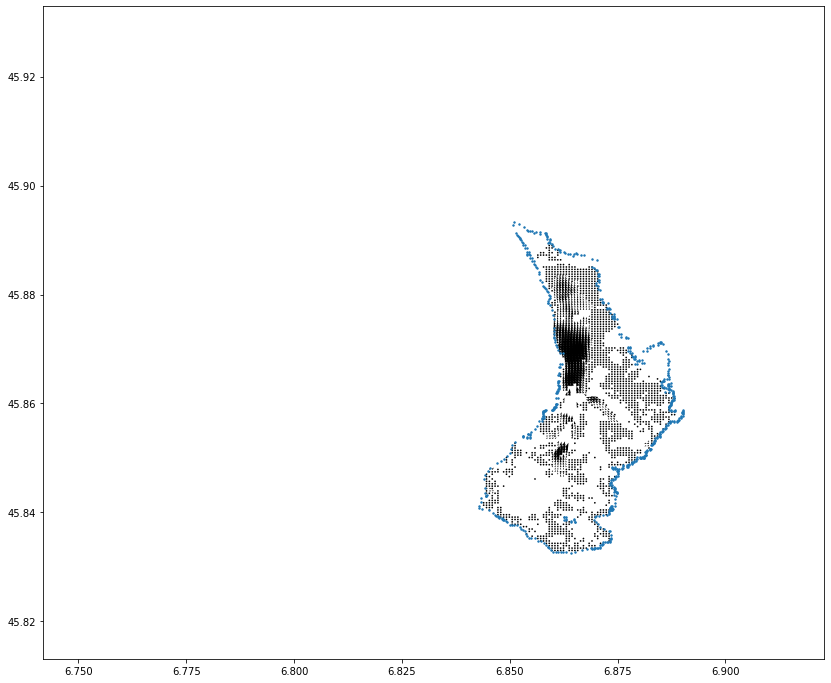

In [8]:
plt.figure(figsize=(14,12))

date = list(dc.tiffs.keys())[indS]

X,Y = np.meshgrid(dc.Xwgs,dc.Ywgs)

vx,vy=dc.getSpeeds()
vx=out[date][0].filled(np.nan)
vy=out[date][1].filled(np.nan)

plt.quiver(X,Y,vx,-vy)

borderPts = np.array(glacierWgs84.geometry.get_coordinates())
plt.scatter(borderPts[:,0], borderPts[:,1], s=2)

plt.show()

In [9]:
def genDataset(dcContainingGlacier, outs):
    Xpts = []
    Yval = []
    cntDiscard = 0
    alreadyInList = {}
    for e,dc in enumerate(tqdm(dcContainingGlacier)):
        X,Y = np.meshgrid(dc.x,dc.y)
        for ti in outs[e]:
            if ti not in alreadyInList: alreadyInList[ti] = {}
            vx=outs[e][ti][0].filled(np.nan)
            vy=outs[e][ti][1].filled(np.nan)
            x,y,vx,vy = X.reshape(-1), Y.reshape(-1), vx.reshape(-1), vy.reshape(-1)
            mask = ~ (np.isnan(vx) | np.isnan(vy))
            ind = np.argwhere(mask)[:,0]
            for i in ind:
                xi = x[i]
                yi = y[i]
                if xi not in alreadyInList[ti]: alreadyInList[ti][xi] = []
                if yi not in alreadyInList[ti][xi]:
                    Xpts.append((xi,yi,ti))
                    Yval.append((vx[i],vy[i]))
                    alreadyInList[ti][xi].append(yi)
                else:
                    cntDiscard += 1
    print(f"{cntDiscard=}")
    Xpts = np.array(Xpts)
    minx, maxx = Xpts[:,0].min(), Xpts[:,0].max()
    miny, maxy = Xpts[:,1].min(), Xpts[:,1].max()
    mint, maxt = Xpts[:,2].min(), Xpts[:,2].max()
    dxy = max(maxx-minx, maxy-miny)
    dt = maxt-mint
    Xpts[:,0] = (Xpts[:,0]-minx)/dxy
    Xpts[:,1] = (Xpts[:,1]-miny)/dxy
    Xpts[:,2] = (Xpts[:,2]-mint)/dt
    Yval = np.array(Yval)
    return Xpts, Yval, dt, mint
outs = [out]
XptsSave, YvalSave, dtSave, mintSave = genDataset(dcContainingGlacier, outs)

100%|██████████| 1/1 [00:04<00:00,  4.19s/it]


cntDiscard=0


In [10]:
Xpts = XptsSave.copy()
Yval = YvalSave.copy()
dt = dtSave.copy()
mint = mintSave.copy()

print(f"{Xpts.shape=}")

Xpts.shape=(2266596, 3)


In [11]:
timeVec = np.unique(Xpts[:,2])

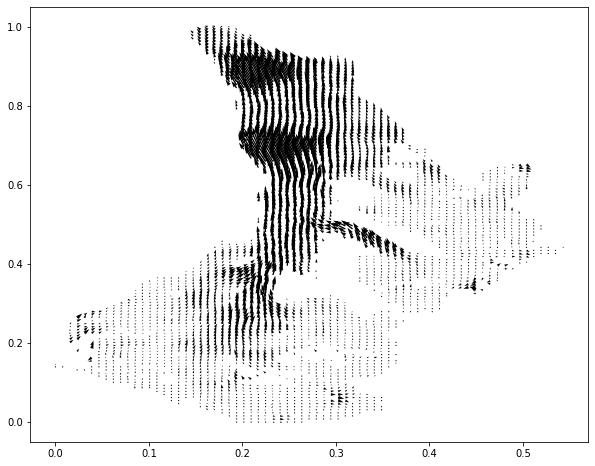

In [12]:
selectedDate = timeVec[10]
ind = np.argwhere(Xpts[:,2]==selectedDate)[:,0]
x = Xpts[ind]
y = Yval[ind]
plt.figure(figsize=(10,8))
plt.quiver(x[:,0],x[:,1],y[:,0],-y[:,1])
plt.show()

2015-08-14 00:00:00
[datetime.datetime(2015, 9, 8, 0, 0), datetime.datetime(2015, 9, 13, 0, 0), datetime.datetime(2015, 9, 18, 0, 0), datetime.datetime(2015, 9, 23, 0, 0), datetime.datetime(2015, 9, 28, 0, 0), datetime.datetime(2015, 10, 3, 0, 0), datetime.datetime(2015, 10, 8, 0, 0), datetime.datetime(2015, 10, 13, 0, 0), datetime.datetime(2015, 10, 18, 0, 0), datetime.datetime(2015, 10, 23, 0, 0), datetime.datetime(2015, 10, 28, 0, 0), datetime.datetime(2015, 11, 2, 0, 0), datetime.datetime(2015, 11, 7, 0, 0), datetime.datetime(2015, 11, 12, 0, 0), datetime.datetime(2015, 11, 17, 0, 0), datetime.datetime(2015, 11, 22, 0, 0), datetime.datetime(2015, 11, 27, 0, 0), datetime.datetime(2015, 12, 2, 0, 0), datetime.datetime(2015, 12, 7, 0, 0), datetime.datetime(2015, 12, 12, 0, 0), datetime.datetime(2015, 12, 17, 0, 0), datetime.datetime(2015, 12, 22, 0, 0), datetime.datetime(2015, 12, 27, 0, 0), datetime.datetime(2016, 1, 1, 0, 0), datetime.datetime(2016, 1, 6, 0, 0), datetime.datetime(20

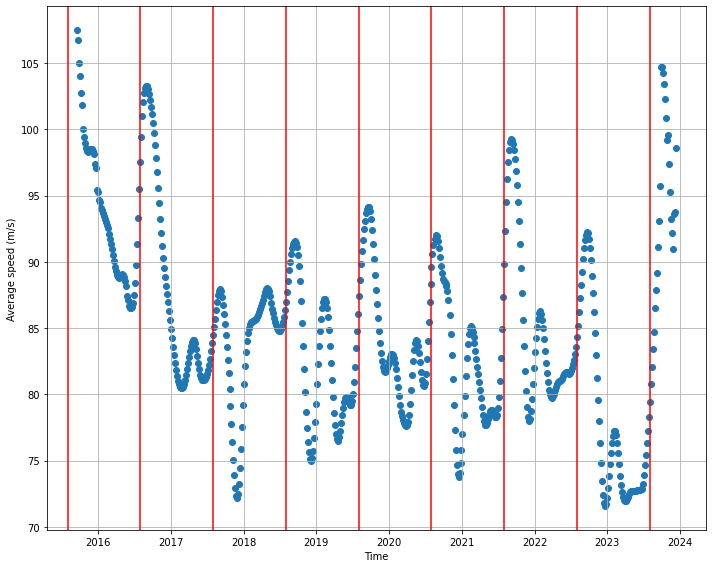

In [16]:
tMean = np.zeros(len(timeVec))
speedMean = np.zeros(len(timeVec))

for e,selectedDate in enumerate(timeVec):
    tMean[e] = selectedDate
    ind = np.argwhere(Xpts[:,2]==selectedDate)[:,0]
    x = Xpts[ind]
    y = Yval[ind]
    speedMean[e] = np.mean(np.linalg.norm(y, axis=1))

startDate = datetime.datetime.strptime("08/14/15", "%m/%d/%y")
print(startDate)
dates = [startDate + datetime.timedelta(days=int(e)) for e in (tMean*dt+mint)]
print(dates)

plt.figure(figsize=(10,8))
plt.scatter(dates[2:], speedMean[2:])
for i in range(15,24):
    plt.axvline(x=datetime.datetime.strptime("08/01/"+str(i), "%m/%d/%y"), color='red')
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Average speed (m/s)")
plt.tight_layout()
plt.show()

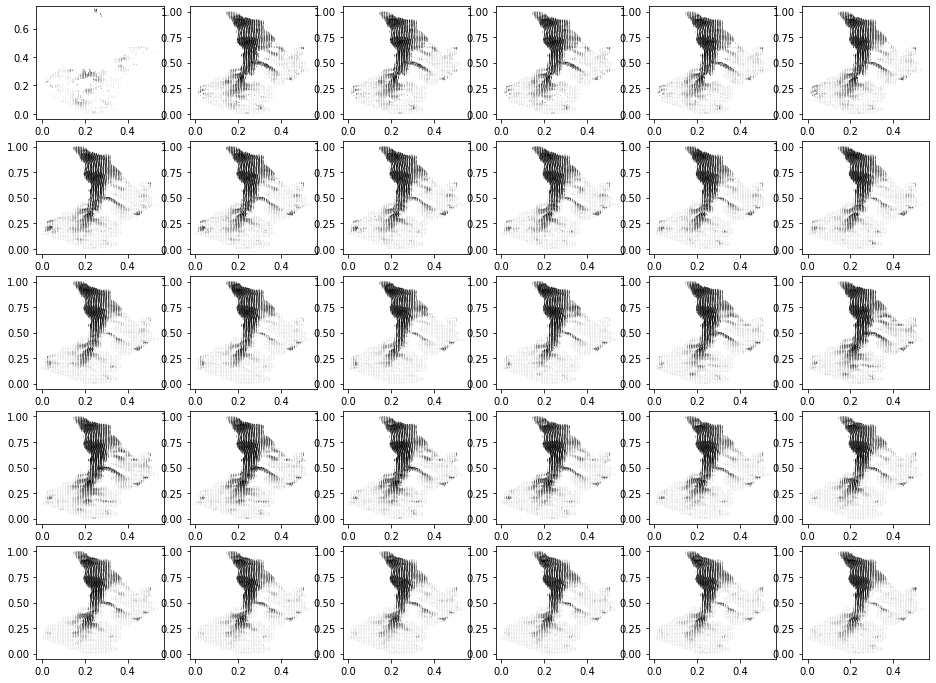

In [17]:
def plotVectorFieldOverTime():
    t = np.unique(Xpts[:,2])[:120:4]

    # Initialize plots
    nrows = int(np.sqrt(len(t)))
    ncols = int(np.ceil(len(t)/nrows))
    f, axs = plt.subplots(nrows, ncols, figsize=(16,12))

    for e,selectedDatePlot in enumerate(t):
        x = Xpts[Xpts[:,2]==selectedDatePlot]
        y = Yval[Xpts[:,2]==selectedDatePlot]

        axs[e//ncols][e%ncols].quiver(x[:,0],x[:,1],y[:,0],-y[:,1], scale=5e3, scale_units='inches')
    plt.show()
plotVectorFieldOverTime()

# Explore raw datacubes from the server

In [ ]:
period = [10, 90]
rgiAreaId = 18 # 18: new_zealand, 11: europe
area = 'new_zealand' # new_zealand, alps
year = [2017, 2018]
user = 'username'

reg = Region(rgiAreaId)

files, fileYears, filePeriods = getServerFiles(area, period, user, year=year, copyLocal=True)
print(len(files))

743


In [10]:
f = files[180]

dc = DataCube(f)
print(dc.mapping)

dc.readAsTiff()

PROJCS["WGS 84 / UTM zone 59S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",171],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32759"]]


100%|██████████| 11/11 [00:02<00:00,  3.95it/s]


In [11]:
bottomlat, leftlon = dc.Ywgs.min(), dc.Xwgs.min()
toplat, rightlon = dc.Ywgs.max(), dc.Xwgs.max()
print(bottomlat, leftlon)
print(toplat, rightlon)

reg.filterArea(thresArea=1)
print(f"{len(reg.glaciersOfInterest)=}")
glaciers = reg.getGlacierInBox(leftlon, rightlon, toplat, bottomlat, useFiltered=True)
print(f"{len(glaciers)=}")

-43.56723905266809 170.1428294560512
-43.454094273155256 170.29539672543112
len(reg.glaciersOfInterest)=143


100%|██████████| 143/143 [00:00<00:00, 315.44it/s]

len(glaciers)=10


[(2017, 2, 16, 0.0), (2017, 2, 26, 0.0), (2017, 3, 28, 0.0), (2017, 5, 17, 0.0), (2017, 5, 27, 0.0), (2017, 6, 6, 0.0), (2017, 7, 31, 0.0), (2017, 9, 29, 0.0), (2017, 10, 9, 0.0), (2017, 10, 19, 0.0), (2017, 12, 3, 0.0)]
RGI2000-v7.0-G-18-01829: None
RGI2000-v7.0-G-18-01830: None
RGI2000-v7.0-G-18-01838: None
RGI2000-v7.0-G-18-01854: None
RGI2000-v7.0-G-18-01855: None
RGI2000-v7.0-G-18-01871: None
RGI2000-v7.0-G-18-01874: None
RGI2000-v7.0-G-18-01930: None
RGI2000-v7.0-G-18-01933: None
RGI2000-v7.0-G-18-02554: None


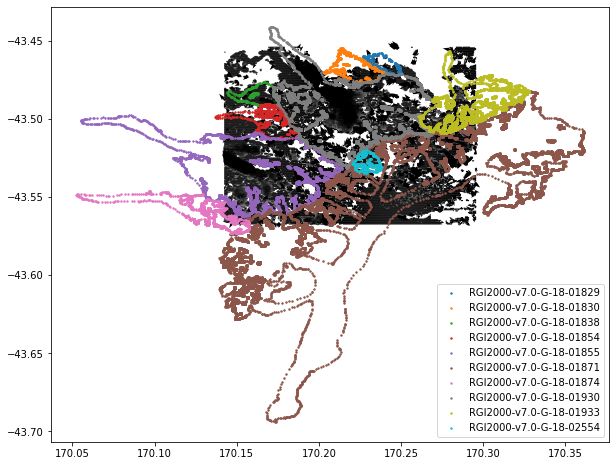

In [ ]:
vx=dc.fnetcdf['vx'][:].filled(np.nan)
vy=dc.fnetcdf['vy'][:].filled(np.nan)

indS = 2
date1 = dc.fnetcdf['date1'][indS]
date2 = dc.fnetcdf['date2'][indS]
t1 = jdcal.jd2gcal(2400000.5, date1)
t2 = jdcal.jd2gcal(2400000.5, date2)
print([jdcal.jd2gcal(2400000.5, d) for d in dc.fnetcdf['date1']])

plt.figure(figsize=(10,8))
plt.quiver(dc.Xwgs,dc.Ywgs,vx[indS],-vy[indS])

for e,glacier in enumerate(glaciers):
    print(f"{glacier['rgi_id'].item()}: {glacier['glac_name'].item()}")
    borderPts = np.array(glacier.geometry.get_coordinates())
    plt.scatter(borderPts[:,0], borderPts[:,1], s=2, label=glacier['rgi_id'].item())
plt.legend(loc=4)
plt.show()

In [13]:
# New Zealand
gid = 'RGI2000-v7.0-G-18-01930'

# Europe
# gid = 'RGI2000-v7.0-G-11-00757'

indS = 2

glacierWgs84 = reg.gdf.loc[reg.gdf.rgi_id==gid]

glacierDc = Glacier(glacierWgs84, files, sortValues=filePeriods)
dcContainingGlacier = glacierDc.getDataCubes()
print(dcContainingGlacier)

743it [00:08, 87.17it/s] 
100%|██████████| 6/6 [00:01<00:00,  4.48it/s]

[<dbExplorer.velocitiesDataCube.DataCube object at 0x79d75e7ce160>, <dbExplorer.velocitiesDataCube.DataCube object at 0x79d7630fb580>, <dbExplorer.velocitiesDataCube.DataCube object at 0x79d7571ba580>, <dbExplorer.velocitiesDataCube.DataCube object at 0x79d76304c2e0>, <dbExplorer.velocitiesDataCube.DataCube object at 0x79d762dae310>, <dbExplorer.velocitiesDataCube.DataCube object at 0x79d762d50d30>, <dbExplorer.velocitiesDataCube.DataCube object at 0x79d762dae250>, <dbExplorer.velocitiesDataCube.DataCube object at 0x79d762dae400>]


In [14]:
outs = []
for dc in dcContainingGlacier:
    out = {}
    for date in dc.tiffs:
        out[date], _ = mask(dc.tiffs[date], glacierWgs84.geometry, invert=False, crop=False, filled=False)
    outs.append(out)

/home/alban/anaconda3/envs/glacio/lib/python3.8/site-packages/matplotlib/quiver.py:628: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
/home/alban/anaconda3/envs/glacio/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


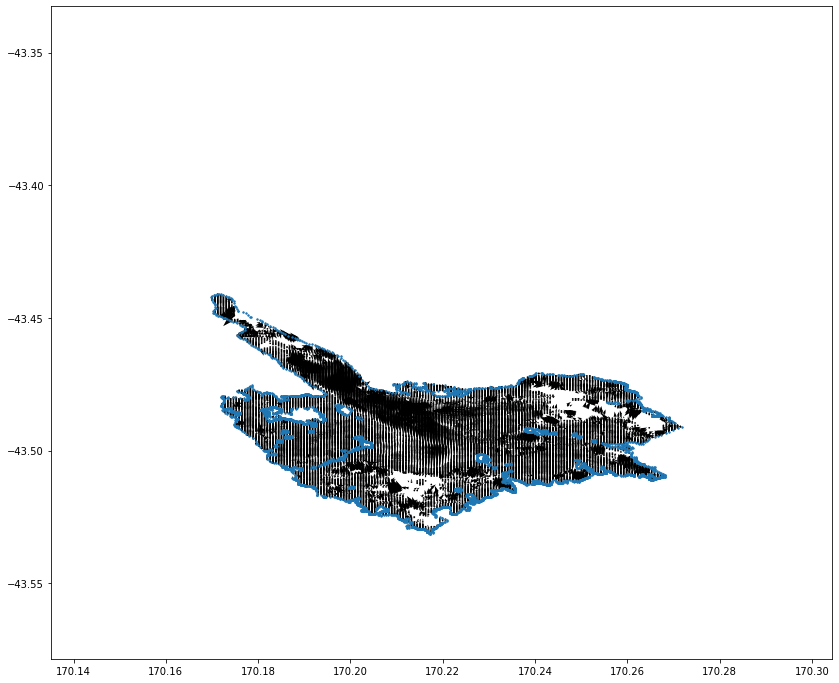

In [ ]:
plt.figure(figsize=(14,12))
for e,dc in enumerate(dcContainingGlacier):
    selectedDate = list(dc.tiffs.keys())[2]
    X,Y = np.meshgrid(dc.Xwgs,dc.Ywgs)
    vx=outs[e][selectedDate][0].filled(np.nan)
    vy=outs[e][selectedDate][1].filled(np.nan)
    plt.quiver(X,Y,vx,-vy)

borderPts = np.array(glacierWgs84.geometry.get_coordinates())
plt.scatter(borderPts[:,0], borderPts[:,1], s=2)
plt.show()